Enter information about new data and run the whole notebook to create a new gaussian cluster map

In [1]:
from os import listdir
from os.path import isfile, join
import folium
import sklearn
import sklearn.mixture
import random
import SURF_peakfinder_program_Emily_Ju as peak
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import helperFunctions as hf
import math
from collections import OrderedDict

# Choose type of file you want to add

In [2]:
#uncomment bike or truck depending on the type of data
transport='bike'
#transport='truck'
if transport =='bike':
    filter_len=500
    threshold=0.05
    mypath='dataBike'
elif transport =='truck':
    filter_len=300
    threshold=0.05
    mypath='dataTruck'

#modify bike files to account for the 30 sec delay of the instrument    
adjustDelay=True # False if already did it
if adjustDelay and transport == 'bike':
    delayedPath='dataBikeOldDelayed'
    filesToBeAdjusted= [f  for f in listdir(delayedPath) if isfile(join(delayedPath, f)) and f[-3:]=="csv" ] # every day
    #filesToBeAdjusted=['sync_data_2019-07-31.csv']
    hf.adjustDelay(filesToBeAdjusted,delayedPath=delayedPath , adjustedPath=mypath)

#choose files
files = [f  for f in listdir(mypath) if isfile(join(mypath, f)) and f[-3:]=="csv" ] # every day
#files=['sync_data_2019-07-31.csv'] # 1 (or a few) day only

#from files get list of dates
onlyDates=[x[10:20] for x in files]

# Find Peak based on height and area under the curve
Finds position and level of peaks and stores them in "areaPeaks/area"+dt+".peaks.csv"

AttributeError: module 'scipy.integrate' has no attribute 'trapz'

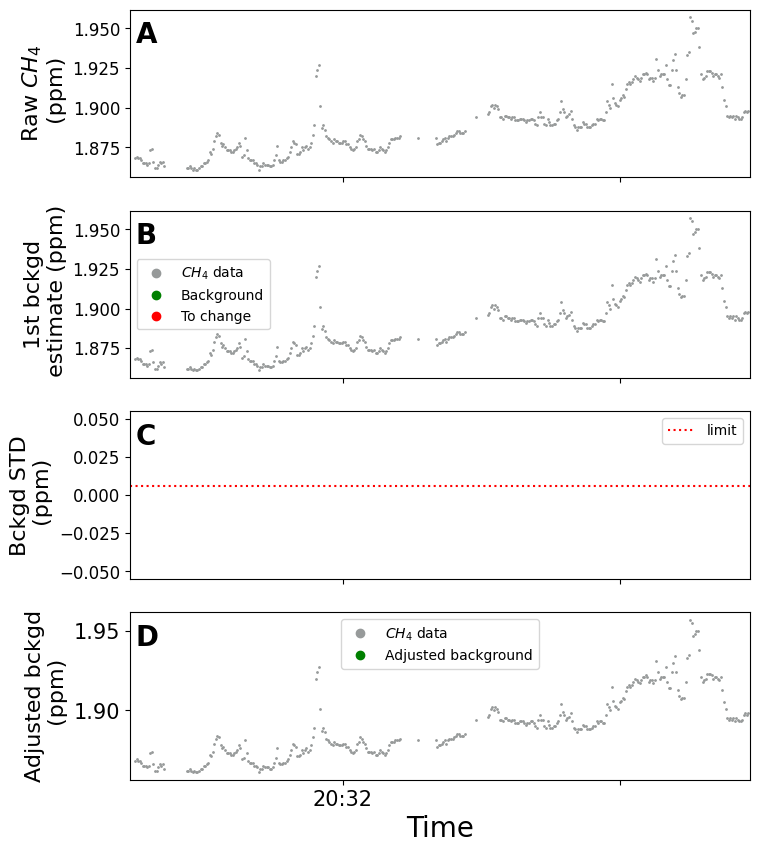

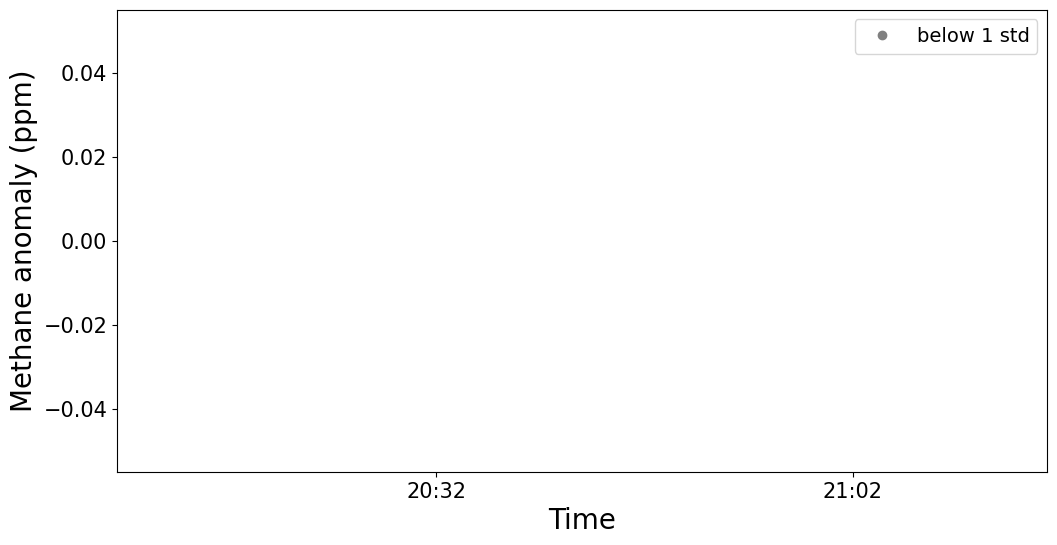

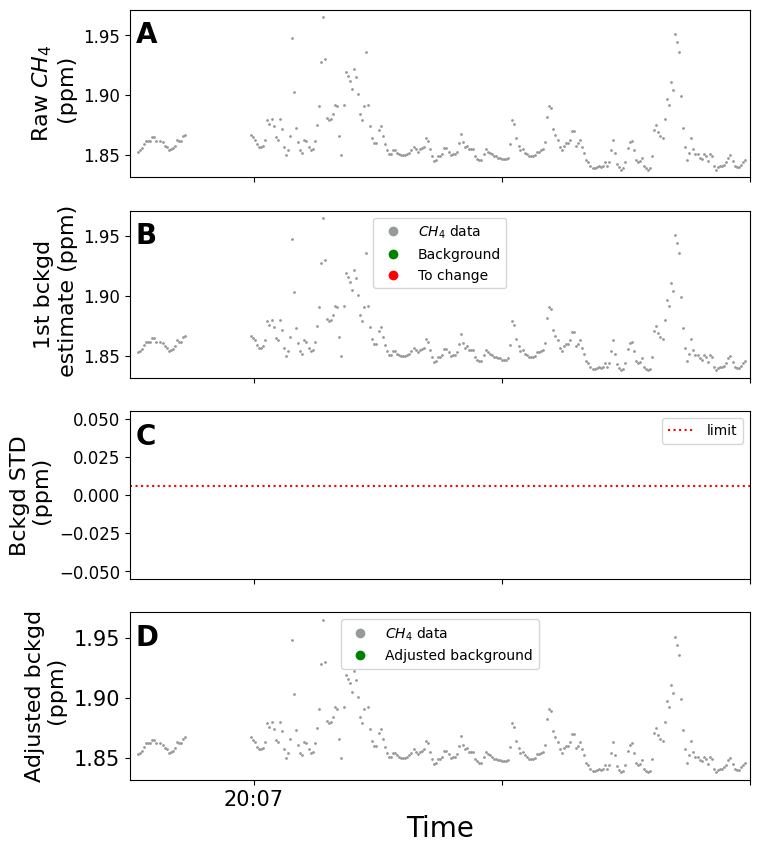

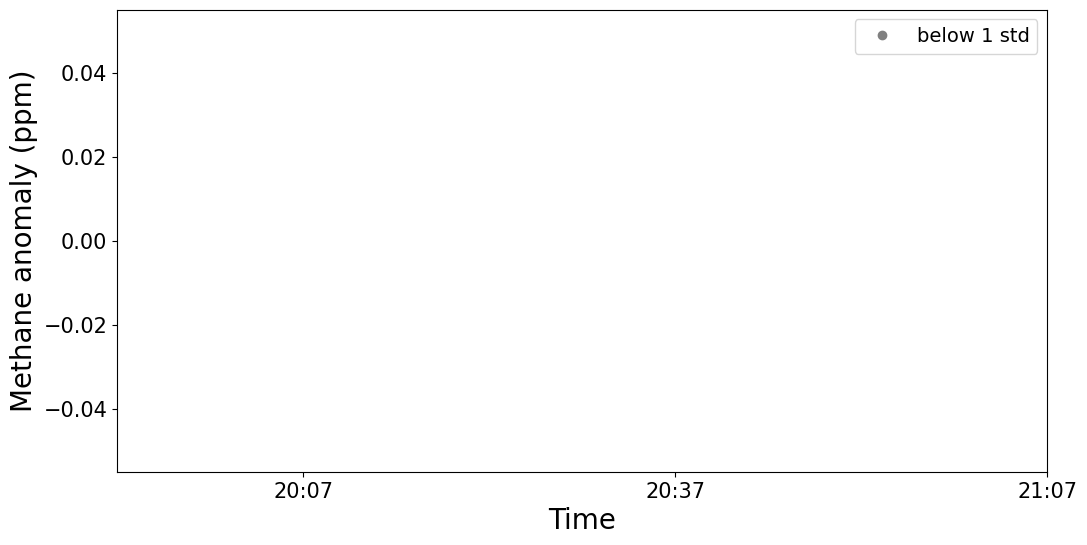

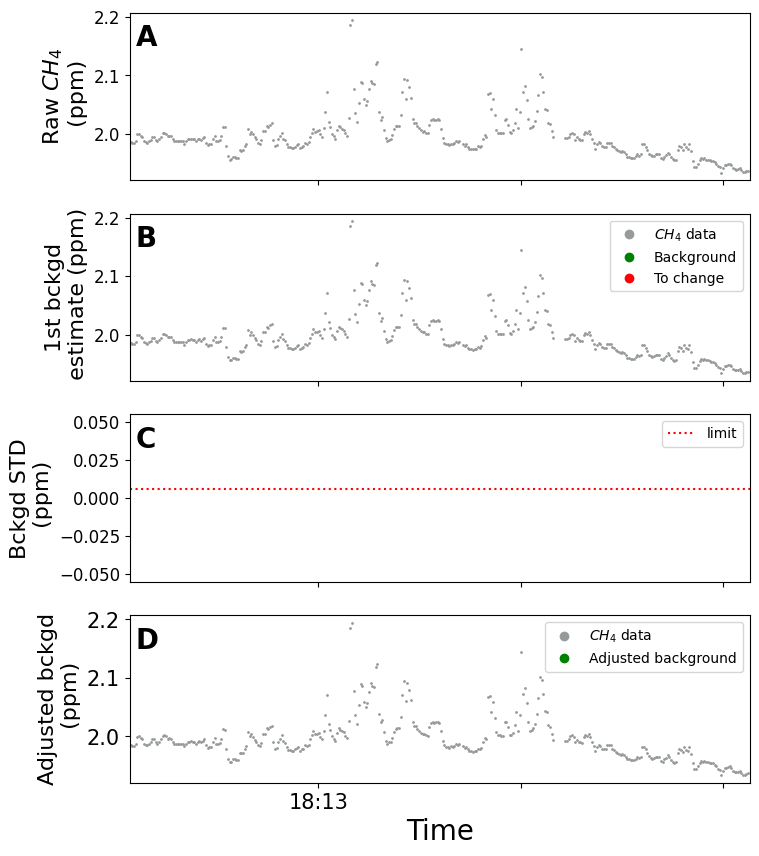

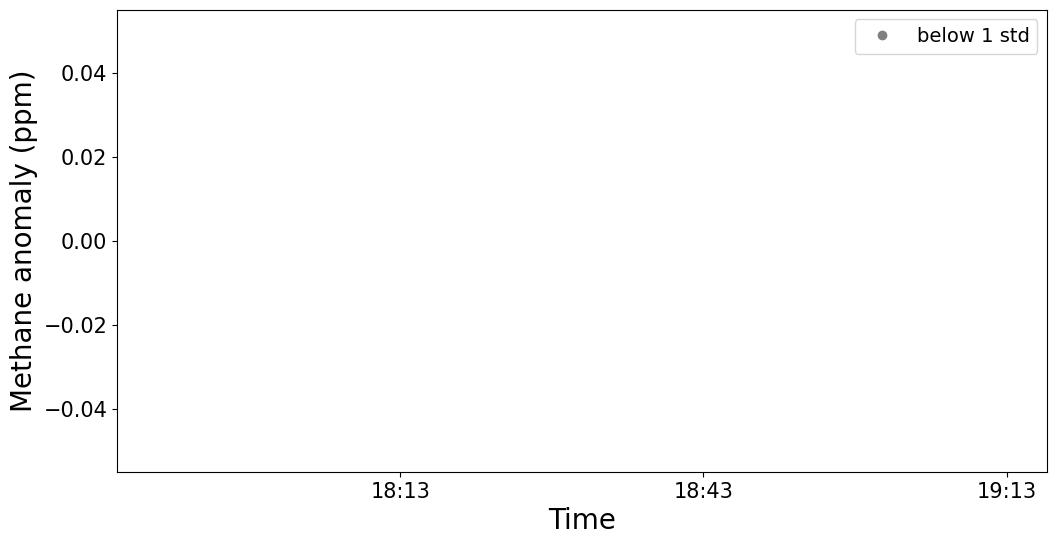

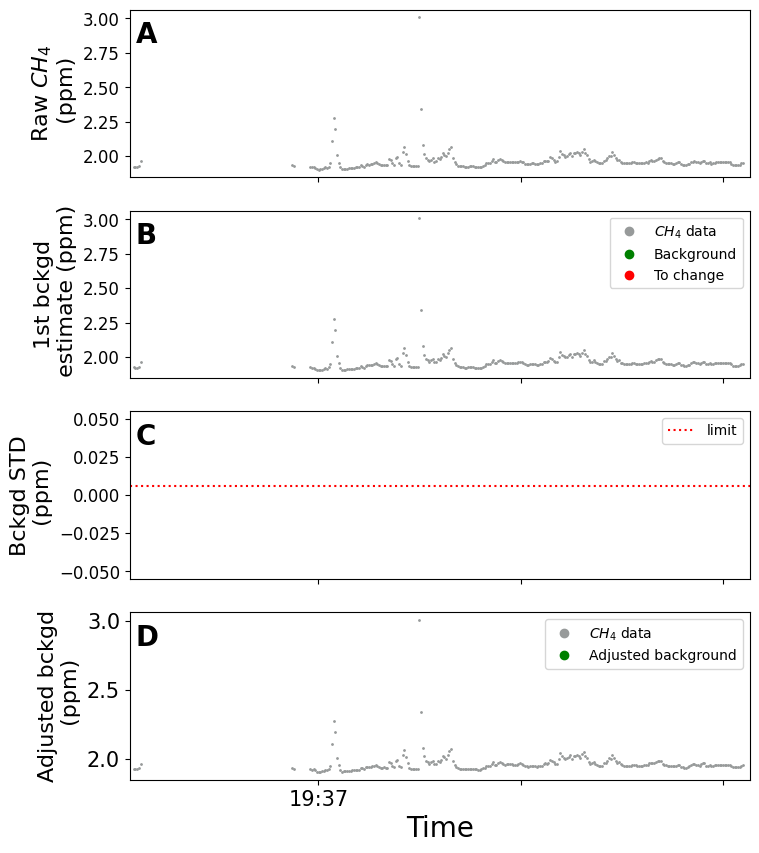

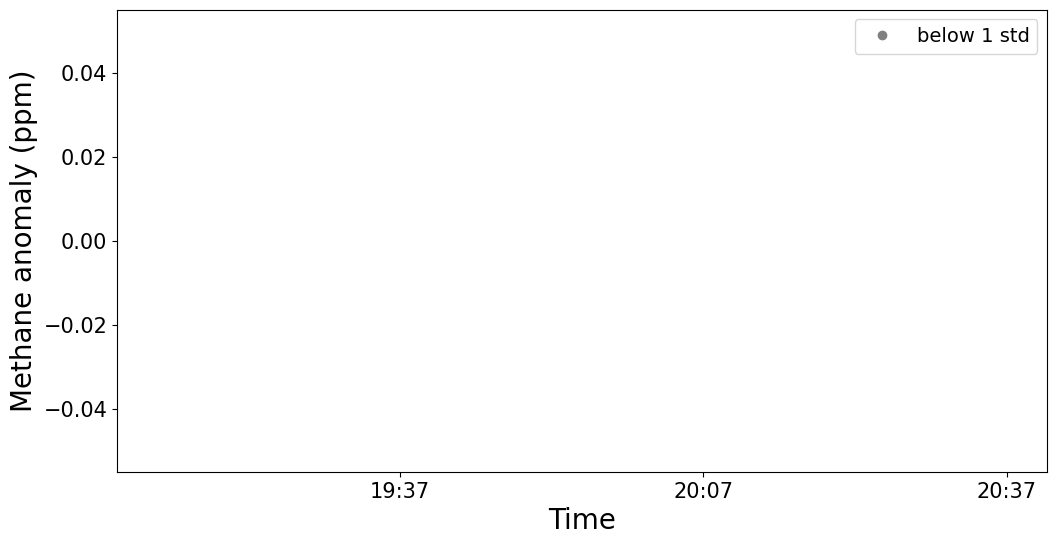

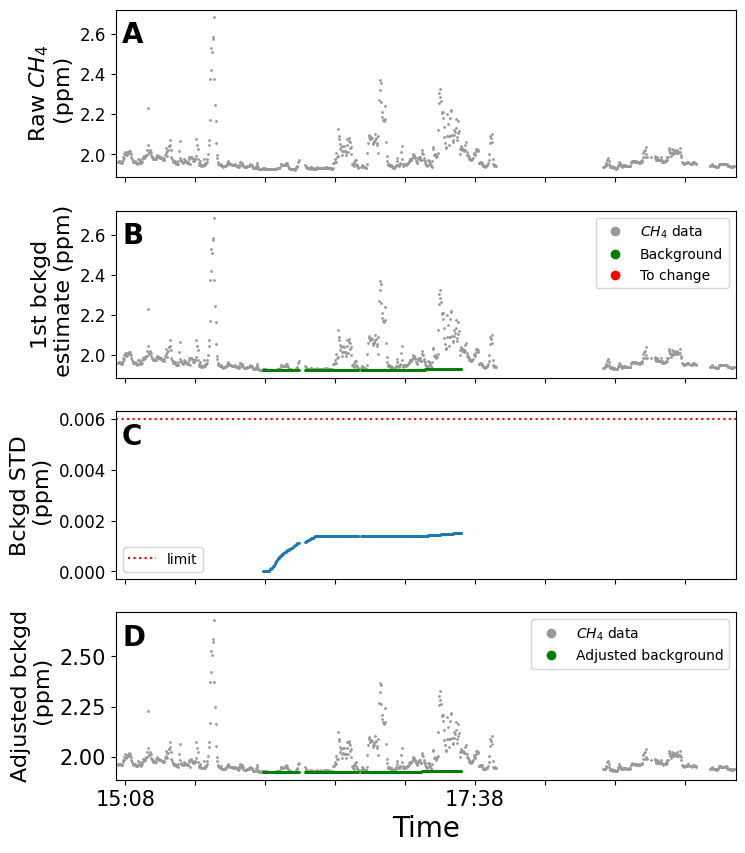

<Figure size 1200x600 with 0 Axes>

In [3]:
for d in onlyDates:
    if transport=='bike':
        file=mypath+"/sync_data_"+d+".csv" #the following if statements account for calibrated files
        if not isfile(file):
            file=mypath+"/sync_data_calibrated_"+d+".csv"
        dt=d
    elif transport=='truck':
        file=mypath+"/sync_data_"+d+"_Truck.csv"
        #To identify truck data we change the '2' for a 't' in the year (2019 -> t019)
        dt = list(d)
        dt[0]='t'
        dt="".join(dt)
    #find peaks and put in areaPeaks directory
    peak.data_analy.areaPeaks(file, filter_len, threshold, dt,limA=[1,8,60], limH=[0.04,0.2,1],transport=transport, show=True)
    #cleaned peak files
    peak.data_analy.clean_file("areaPeaks/area"+dt+".peaks.csv")

# Load level 2 and 3 peaks and correct for level and wind

Text(0, 0.5, 'Latitude')

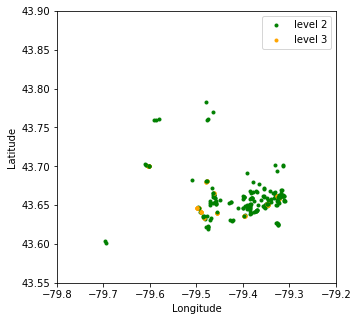

In [ ]:
#correct for level and wind
#put peaks from dataframe to x array format
areaPath='areaPeaks'
#Plot bike/truck data ( add '2'/'t' to start list)
cleanedFiles = [areaPath+"/"+f for f in listdir(areaPath) if isfile(join(areaPath, f)) and
                f[-11:]=='cleaned.csv'  and f[4]=='2' and f!='area2019-07-10.peaks_cleaned.csv' and f!='area2019-07-04.peaks_cleaned.csv']
col=['blue','red','green','orange']# color for level
xAc=[]# list of corrected coordinates of level 2-3 peaks
plt.figure(figsize=(5,5))
for f in cleanedFiles:
    peaks=pd.read_csv(f)
    for i in range(peaks.shape[0]):
        long, lat = peaks["Longitude"][i],peaks['Latitude'][i]
        #load wind data
        wd=math.radians(peaks['wd_corr'][i])
        ws=peaks['ws_corr'][i]
        mult=5e-05# force of displacement
        #move peaks along wind direction with factor mult*wind speed
        corrLong= long- (mult*ws*math.cos(wd))
        corrLat= lat- (mult*ws*math.sin(wd))
        if peaks["Level"][i]==2:
            plt.plot(corrLong,corrLat,'.',linestyle='none',color=col[peaks["Level"][i]], label="level "+str(peaks["Level"][i]))
            xAc.append([corrLong,corrLat])
        #if level 3 add more point because  peak is more important
        if peaks["Level"][i]==3:
            for count in range(3):
                plt.plot(corrLong,corrLat,'.',linestyle='none',color=col[peaks["Level"][i]], label="level "+str(peaks["Level"][i]))
                xAc.append([corrLong,corrLat])
        
#legend. write only once each label            
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlim((-79.8,-79.2))
plt.ylim((43.55,43.9))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#alone,xAc,_,_=hf.separate( xAc, limit=0.01)# remove alone points from gaussian mixture



# Apply Gaussian Mixture to find cluster
This has only been tested on bike data.
If you don't want the wind correction, make mult=0

In [ ]:


#gaussian mixture
n=23# number of cluster
#learn gaussians
gmAc =sklearn.mixture.GaussianMixture(n_components=n, covariance_type='full',random_state=3715688689).fit(xAc)
#predict label (cluster) for each point
label=gmAc.predict(xAc)
#plot map. color by cluster
m=hf.clusterMap(xAc,label,n,showMeans=True, showFacilities=True,means=gmAc.means_,covariances=gmAc.covariances_,save=True, name='GaussianClusters',alone=alone)
print(m)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# optimize parameter of gaussian mixture
Only run this once in a while to adjust the parameters if you need to have the best possible cluster analysis. The replace mult, random_state and n in the cells above.


In [ ]:
"""
areaPath='areaPeaks'
cleanedFiles = [areaPath+"/"+f for f in listdir(areaPath) if isfile(join(areaPath, f)) and f[-11:]=='cleaned.csv'  and f[4]=='2' and f!='area2019-07-10.peaks_cleaned.csv'and f!='area2019-07-04.peaks_cleaned.csv']

mult, sil, random_state, n=hf.bestParam(cleanedFiles,nRan=range(20,28), rRan=range(25),verbose=True)
print(mult, sil, random_state, n)
"""
